In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from scipy.optimize import curve_fit
from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

In [2]:
scan_name ="XAS-L-cystine-timescan"
# scan_range = ".run001463-001483"
scan_range = ".run002376-002396"

DIR = "/sf/alvra/data/p18387/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p18387/res/scan_info/"


!ls -lah -rt $DIR | grep BSREAD
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

-rw-r--r--.  1 root p18387 531M Feb 22 20:55 run_002018.BSREAD.h5
-rw-r--r--.  1 root p18387 652M Feb 22 20:55 run_002018.BSREAD.IMAGES.h5
-rw-r--r--.  1 root p18387 531M Feb 22 20:56 run_002019.BSREAD.h5
-rw-r--r--.  1 root p18387 652M Feb 22 20:56 run_002019.BSREAD.IMAGES.h5
-rw-r--r--.  1 root p18387 531M Feb 22 20:57 run_002020.BSREAD.h5
-rw-r--r--.  1 root p18387 652M Feb 22 20:57 run_002020.BSREAD.IMAGES.h5
-rw-r--r--.  1 root p18387 531M Feb 22 20:57 run_002021.BSREAD.h5
-rw-r--r--.  1 root p18387 652M Feb 22 20:57 run_002021.BSREAD.IMAGES.h5
-rw-r--r--.  1 root p18387 531M Feb 22 20:58 run_002022.BSREAD.h5
-rw-r--r--.  1 root p18387 652M Feb 22 20:58 run_002022.BSREAD.IMAGES.h5
-rw-r--r--.  1 root p18387 531M Feb 22 20:59 run_002023.BSREAD.h5
-rw-r--r--.  1 root p18387 652M Feb 22 20:59 run_002023.BSREAD.IMAGES.h5
-rw-r--r--.  1 root p18387 531M Feb 22 21:00 run_002024.BSREAD.h5
-rw-r--r--.  1 root p18387 652M Feb 22 21:00 run_002024.BSREAD.IMAGES.h5
-rw-r--r--.  1 root p18387 

ra-c-002.psi.ch
There are 318 files in the folder /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/


# Load one step and filter some data from I0

In [4]:
#f ="RuDimerACN_monoscan_0p6ps_018_step0003.BSREAD.h5"
f ="run_001422.BSREAD.h5"
fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(fn, channel_energy)

IzeroFEL_pump_original = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_original = IzeroFEL_unpump_shot.copy()
print ("Energy {} eV".format(Energy_shot.mean()))


conditionPumpMax = IzeroFEL_pump_shot < np.median(IzeroFEL_pump_shot)+3*(np.std(IzeroFEL_pump_shot))
conditionPumpMin = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-3*(np.std(IzeroFEL_pump_shot))

conditionUnPumpMax = IzeroFEL_unpump_shot < np.median(IzeroFEL_unpump_shot)+3*(np.std(IzeroFEL_unpump_shot))
conditionUnPumpMin = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-3*(np.std(IzeroFEL_unpump_shot))

conditionGeneral = IzeroFEL_pump_shot > 0.01
conditionGeneral2 = IzeroFEL_unpump_shot > 0.01

IzeroFEL_pump_shot = IzeroFEL_pump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

DataFluo_pump_shot = DataFluo_pump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]
#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

IzeroFEL_pump_shot = np.asarray(IzeroFEL_pump_shot)
IzeroFEL_pump_original = np.asarray(IzeroFEL_pump_original)

print (IzeroFEL_pump_original.shape, IzeroFEL_unpump_original.shape)
print (IzeroFEL_pump_shot.shape, IzeroFEL_unpump_shot.shape)

print ("Median value Izero = {}".format(np.median(IzeroFEL_pump_shot)))# - 2*(np.std(IzeroFEL_pump_shot))
print ("Median value fluo = {}".format(np.median(DataFluo_pump_shot)))# - 2*(np.std(IzeroFEL_pump_shot)))
run001463-001483

Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 998 shots each
Energy 2466.495235563125 eV
(998,) (998,)
(933,) (933,)
Median value Izero = 0.34412533417344093
Median value fluo = 0.069580078125


# Load time scan

In [3]:
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 51

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

DataTrans_pump = []
DataTrans_unpump = []
err_DataTrans_pump = []
err_DataTrans_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: # and i!=8:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(filename, channel_delay)
        
        ###################I0 threshold: to make threshold#########################
        threshold_pump = IzeroFEL_pump_shot > 0.1
        threshold_unpump = IzeroFEL_unpump_shot > 0.1
        threshold_pump_shot = DataFluo_pump_shot > 0.0001
        threshold_unpump_shot = DataFluo_unpump_shot > 0.0001
        ##########################################################################
        
        ###################I0 threshold: to calculation for avg#########################
        _threshold_pump = IzeroFEL_pump_shot > 0.1
        _threshold_unpump = IzeroFEL_unpump_shot > 0.1
        _threshold_pump_shot = DataFluo_pump_shot > 0.0001
        _threshold_unpump_shot = DataFluo_unpump_shot > 0.0001
        ################################################################################
        
        scale_I0 = 4
        ############################I0 maximum#####################
        condition_pump = IzeroFEL_pump_shot < np.median(IzeroFEL_pump_shot)+scale_I0*(np.std(IzeroFEL_pump_shot))
#         print (np.median(IzeroFEL_pump_shot)+scale_I0*(np.std(IzeroFEL_pump_shot)))
        condition_unpump = IzeroFEL_unpump_shot < np.median(IzeroFEL_unpump_shot)+scale_I0*(np.std(IzeroFEL_unpump_shot))

        DataFluo_pump_shot_ = DataFluo_pump_shot[condition_pump & threshold_pump & threshold_pump_shot]
        IzeroFEL_pump_shot_ = IzeroFEL_pump_shot[condition_pump & threshold_pump & threshold_pump_shot]
#         DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
#         IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
#       DataTrans_pump_shot = DataTrans_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
        DataFluo_unpump_shot_ = DataFluo_unpump_shot[condition_unpump & threshold_unpump & threshold_unpump_shot]
        IzeroFEL_unpump_shot_ = IzeroFEL_unpump_shot[condition_unpump & threshold_unpump & threshold_unpump_shot]
#         DataFluo_unpump_shot = DataFluo_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
#         IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
#       DataTrans_unpump_shot = DataTrans_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
              
        DataFluo_pump_shot_norm_ = DataFluo_pump_shot_ / IzeroFEL_pump_shot_
        DataFluo_unpump_shot_norm_ = DataFluo_unpump_shot_ / IzeroFEL_unpump_shot_
        
        scale_std = 1
        ###########Data Selection for pump####################
        avg = np.average(DataFluo_pump_shot_norm_)
        std = np.std(DataFluo_pump_shot_norm_)
        _DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & _threshold_pump & _threshold_pump_shot]
        _IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & _threshold_pump & _threshold_pump_shot]
        tData_pump = np.array([x for x in  _DataFluo_pump_shot/_IzeroFEL_pump_shot if abs(x-avg) <= scale_std*std ])
        DataFluo_pump.append(np.average(tData_pump))
        err_DataFluo_pump.append(np.std(tData_pump)/math.sqrt(len(tData_pump)))
        
        
        ###########Data Selection for unpump####################
        avg = np.average(DataFluo_unpump_shot_norm_)
        std = np.std(DataFluo_unpump_shot_norm_)
        _DataFluo_unpump_shot = DataFluo_unpump_shot[condition_unpump & _threshold_unpump & _threshold_unpump_shot]
        _IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_unpump & _threshold_unpump & _threshold_unpump_shot]
        tData_unpump = np.array([x for x in  _DataFluo_unpump_shot/_IzeroFEL_unpump_shot if abs(x-avg) <= scale_std*std ])
        DataFluo_unpump.append(np.average(tData_unpump))
        err_DataFluo_unpump.append(np.std(tData_unpump)/math.sqrt(len(tData_unpump)))
        
               
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
# DataTrans_pump = np.asarray(DataTrans_pump)
# DataTrans_unpump = np.asarray(DataTrans_unpump)
              
# Pump_probe = np.asarray(Pump_probe)
# err_Pump_probe = np.asarray(err_Pump_probe)
              
err_DataFluo_pump = np.asarray(err_DataFluo_pump)
err_DataFluo_unpump = np.asarray(err_DataFluo_unpump)
# err_DataTrans_pump = np.asarray(err_DataTrans_pump)
# err_DataTrans_unpump = np.asarray(err_DataTrans_unpump)
            
Delay_mm = np.asarray(Delay_mm)

print ("Job done!")

/sf/alvra/data/p18387/res/scan_info/XAS-L-cystine-timescan.run002376-002396.json
Processing 21 files
step 1 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002376.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 998 shots each
step 2 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002377.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 998 shots each
step 3 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002378.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 999 shots each
step 4 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002379.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 998 shots each
step 5 of 21 : Processing /sf/alvra/data/p18387/raw/scan_data/XAS-L-cystine-timescan/run_002380.BSREAD.h5
Found 3999 shots in the file
Load

# Plot time scans

<IPython.core.display.Javascript object>


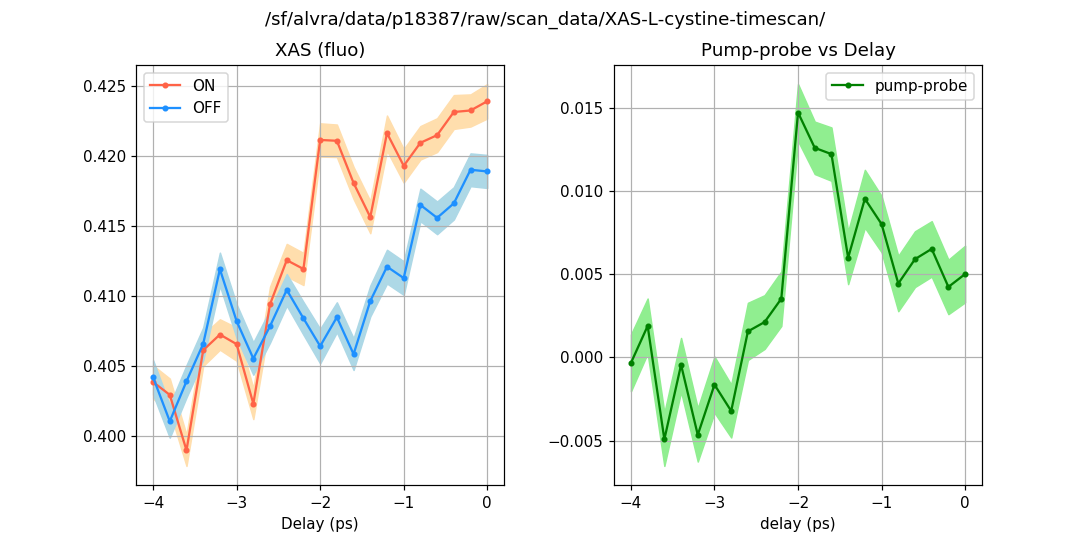

In [4]:
#Timezero = 141.36   # position of Timezero on PP delay (in mm!)
#Timezero = 160.0317   # position of Timezero on PP delay (in mm!)
Timezero = 177.65   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !
#Delay_ps = Delay_mm
scale=1


plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)

#plt.title(DIR,horizontalalignment='right')
low_err_pump = DataFluo_pump - err_DataFluo_pump
high_err_pump = DataFluo_pump + err_DataFluo_pump
low_err_unpump = DataFluo_unpump - err_DataFluo_unpump
high_err_unpump = DataFluo_unpump + err_DataFluo_unpump
Pump_probe = DataFluo_pump - DataFluo_unpump 
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

plt.subplot(1,2,1)
plt.plot(Delay_ps, scale*DataFluo_pump, label="ON",marker='.',color='tomato')
plt.plot(Delay_ps, scale*DataFluo_unpump, label="OFF",marker='.',color='dodgerblue')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='navajowhite')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='lightblue')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Delay_ps, scale*(Pump_probe), label="pump-probe",marker='.',color='green')
plt.fill_between(Delay_ps, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightgreen')
plt.grid()
plt.xlabel("delay (ps)")
plt.gca().set_title('Pump-probe vs Delay')
plt.legend(loc="best")

plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

In [ ]:
Pump_probe_tofit = (Pump_probe/DataFluo_unpump).copy()
Delay_mm_tofit = Delay_mm.copy()
Delay_ps_tofit = Delay_ps.copy()

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_mm_tofit) | np.isnan(Pump_probe_tofit))

parameters,extras = curve_fit(errfunc_fwhm, Delay_mm_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 155, 0.5])

print("Position t0 =",np.round(parameters[2],5),"mm")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"um")

In [ ]:
#... and the plot with the fit curve

plt.figure()

plt.plot(Delay_mm_tofit, Pump_probe_tofit, label=f"{scan_name}",marker='.')
plt.plot(Delay_mm_tofit, errfunc_fwhm(Delay_mm_tofit,*parameters))

#low_err = Pump_probe_tofit - err_pump_probe
#high_err = Pump_probe_tofit + err_pump_probe
#plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
plt.title('t0=' + str(np.round(parameters[2], 5)) + ' mm' )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_tofit) | np.isnan(Pump_probe_tofit))

parameters,extras = curve_fit(errfunc_fwhm, Delay_ps_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 0, 0.5])

print("Position t0 =",np.round(parameters[2],5),"ps")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

In [ ]:
#... and the plot with the fit curve

plt.figure()

plt.plot(Delay_ps_tofit, Pump_probe_tofit, label=f"{scan_name}",marker='.')
plt.plot(Delay_ps_tofit, errfunc_fwhm(Delay_ps_tofit,*parameters))

#low_err = Pump_probe_tofit - err_pump_probe
#high_err = Pump_probe_tofit + err_pump_probe
#plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
plt.title('width=' + str(np.round(parameters[3]*1000, 5)) + ' fs' )
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [ ]:
timelist=np.concatenate((np.arange(-1.5,-0.5-1,-1))-, np.arange(2847,2845.5-.5,-0.5),np.arange(2845,2835.25-.25,-0.25),np.arange(2835,2834.5-.5,-0.5),np.arange(2834,2831-1,-1)))

In [ ]:
def exponential_func(x,a,b,c):
    return a*np.exp(-b*x)+c

def bi_exponential_func(x,a,b,c, d, e):
    return a*np.exp(-b*x)+c+d*np.exp(-e*x)

Delay_ps = np.array(Delay_ps)
t_range = Delay_ps > 0.02 

popt,pcov = curve_fit(exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 10, 0.2))
popt2,pcov2 = curve_fit(bi_exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 0.6, 0.2, 0.4, 6))

xx= np.linspace(0, 20, 100)
yy = exponential_func(xx, *popt)
yyy= bi_exponential_func(xx, *popt2)

plt.figure()
plt.plot(Delay_ps, -Pump_probe)
plt.plot(xx, yy)
plt.plot(xx, yyy)


print(popt)
print(popt2)
